# Overview of Dataset
**This dataset contains 4242 images of flowers.The data collection is based on the data flicr, google images, yandex images.You can use this datastet to recognize plants from the photo.The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion.
For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!**
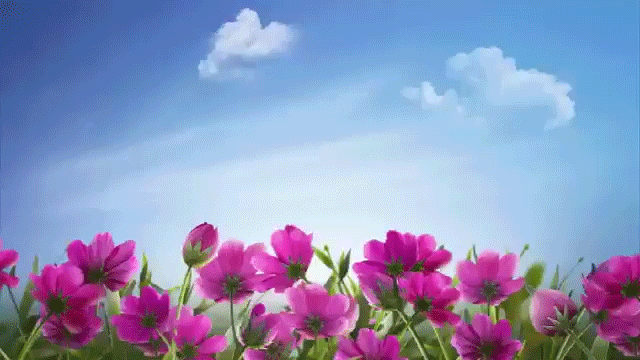

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/flowers-recognition/flowers/dandelion/34578947551_863af3acb3_n.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/2625836599_03e192266f.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/16242239484_51286673af.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/5716633491_55e6f02645_n.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/34697163155_5dc2571f23_n.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/34686041416_e50c8028f9_n.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/8719032054_9a3ce4f0ff.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/9472854850_fc9e1db673.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/31530587330_ba31bd196e_n.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/9293460423_7fbb1e3c32_n.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/9939430464_5f5861ebab.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/2535769822_513be6bbe9.jpg
/kaggle/input/flowers-recognition/flowers/dande

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.applications import VGG19,Resnet
import cv2
import os
import random
import tensorflow as tf

Using TensorFlow backend.


ImportError: cannot import name 'Resnet' from 'keras.applications' (/opt/conda/lib/python3.7/site-packages/keras/applications/__init__.py)

# Loading the Dataset

In [ ]:
labels = ['dandelion', 'daisy','tulip','sunflower','rose']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
data = get_data("/kaggle/input/flowers-recognition/flowers")

# Data Visualization and Preprocessing

In [ ]:
l = []
for i in data:
    l.append(labels[i[1]])
sns.set_style('dark')
sns.countplot(l)

**The dataset seems balanced as for each training label , enough training examples exist**

**Randomly Previewing first 10 images**

In [ ]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=random.randint(0,len(data))
        ax[i,j].imshow(data[l][0])
        ax[i,j].set_title('Flower: '+labels[data[l][1]])
        
plt.tight_layout()

In [ ]:
x = []
y = []

for feature, label in data:
    x.append(feature)
    y.append(label)

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [ ]:
# Normalize the data
x = np.array(x) / 255

In [ ]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's 
x = x.reshape(-1, img_size, img_size, 3)
y = np.array(y)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(y)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x , y , test_size = 0.2 , stratify = y , random_state = 0)

# <font color='purple'>CONVOLUTIONAL NEURAL NETWORKS TO THE RESCUE</font>
A Convolutional Neural Network is a special type of an Artificial Intelligence implementation which uses a  special mathematical matrix manipulation called the convolution operation to process data from the images.

* A **convolution** does this by multiplying two matrices and yielding a third, smaller matrix. 
* The Network takes an input image, and uses a filter **(or kernel)**  to create a **feature map** describing the image. 
* In the convolution operation, we take a filter (usually 2x2 or 3x3 matrix ) and **slide** it over the image matrix. The coresponding numbers in both matrices are multiplied and and added to yield a single number describing that input space. This process is repeated all over the image.This can be seen in the following animation
![https://cdn-images-1.medium.com/max/800/1*VVvdh-BUKFh2pwDD0kPeRA@2x.gif](https://cdn-images-1.medium.com/max/800/1*VVvdh-BUKFh2pwDD0kPeRA@2x.gif)                                     

-------> This is a 2-D representation of calculations happening in 3 dimensions. This is what is actually happening 
![Source: https://cdn-images-1.medium.com/max/800/1*EuSjHyyDRPAQUdKCKLTgIQ.png](https://cdn-images-1.medium.com/max/800/1*EuSjHyyDRPAQUdKCKLTgIQ.png)      

* We use different filters to pass over our inputs, and take all the feature maps, put them together as the final output of the convolutional layer.
* We then pass the output of this layer through a non-linear activation function. The most commonly used one is ReLU. 
* The next step of our process involves further reducing the dimensionality of the data which will lower the computation power required for training this model. This is      achieved by using a **Pooling Layer.** The most commonly used one is **max pooling** which takes the maximum value in the window created by a filter. This              significantly reduces the training time and preserves significant information. 
![https://cdn-images-1.medium.com/max/800/1*vbfPq-HvBCkAcZhiSTZybg.png](https://cdn-images-1.medium.com/max/800/1*vbfPq-HvBCkAcZhiSTZybg.png)

Two of the most commonly associated words with CNN are **stride** and **padding **

**STRIDE:** Stride just means the amount a filter moves during a covolution operation. So, a stride of 1 means that the filter will slide 1 pixel after each covolution operation as shown in this animation.
![https://cdn-images-1.medium.com/max/800/0*iqNdZWyNeCr5tCkc.](https://cdn-images-1.medium.com/max/800/0*iqNdZWyNeCr5tCkc.)

**PADDING:** Padding is just zero value pixels that surround the input image. This protects the loss of any valuable information since the feature map is ever shrinking. 

In [ ]:
del x,y,data

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

# Training The Model

In [ ]:
with strategy.scope():
    pre_trained_model = VGG19(input_shape=(224,224,3), include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers[:19]:
        layer.trainable = False

    model = Sequential([
        pre_trained_model,
        MaxPool2D((2,2) , strides = 2),
        Flatten(),
        Dense(5 , activation='softmax')])
    model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

In [ ]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(x_train,y_train, batch_size = 64 , epochs = 12 , validation_data = (x_test, y_test),callbacks = [learning_rate_reduction])

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

# Analysis after Model Training

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
predictions = model.predict_classes(x_test)
predictions[:5]

In [ ]:
y_test_inv = label_binarizer.inverse_transform(y_test)

In [ ]:
print(classification_report(y_test_inv, predictions, target_names = labels))

In [ ]:
cm = confusion_matrix(y_test_inv,predictions)
cm

In [ ]:
cm = pd.DataFrame(cm , index = labels , columns = labels)

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = labels , yticklabels = labels)

In [ ]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test_inv)):
    if(y_test_inv[i] == predictions[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test_inv)):
    if(y_test_inv[i] != predictions[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

**CORRECTLY CLASSIFIED FLOWER IMAGES**

In [ ]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+ labels[predictions[prop_class[count]]] +"\n"+"Actual Flower : "+ labels[y_test_inv[prop_class[count]]])
        plt.tight_layout()
        count+=1

**INCORRECTLY CLASSIFIED FLOWER IMAGES**

In [ ]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+labels[predictions[mis_class[count]]]+"\n"+"Actual Flower : "+labels[y_test_inv[mis_class[count]]])
        plt.tight_layout()
        count+=1

**Pls upvote the notebook if you like it . It will help me to stay motivated and post more such stuff. Thanks for your time!**